# Pixeltable Processing Pipeline

In this notebook, we'll explore the video processing pipeline we've implemented using Pixeltable. The idea is to get an intuition of what Pixeltable does and also understand what the MCP server will be doing under the hood.

If you want to add your own videos for this notebook, please make sure you have converted them using this command: 

`make convert-video input=<input_video_path> output=<output_video_path>`

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
video_path = "./data/pass_the_butter_rick_and_morty.mp4"

### Creating the video table and inserting the video

In [3]:
import pixeltable as pxt

pxt.drop_dir("test", force=True)
pxt.create_dir("test")

video_table = pxt.create_table(
    'test.videos', 
    schema={'video': pxt.Video},
    if_exists="replace_force"
)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/moteroperdido/.pixeltable/pgdata
Created directory 'test'.
Created table `videos`.


In [4]:
video_table.insert([{'video': video_path}])

Inserting rows into `videos`: 1 rows [00:00, 13.83 rows/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

video
""

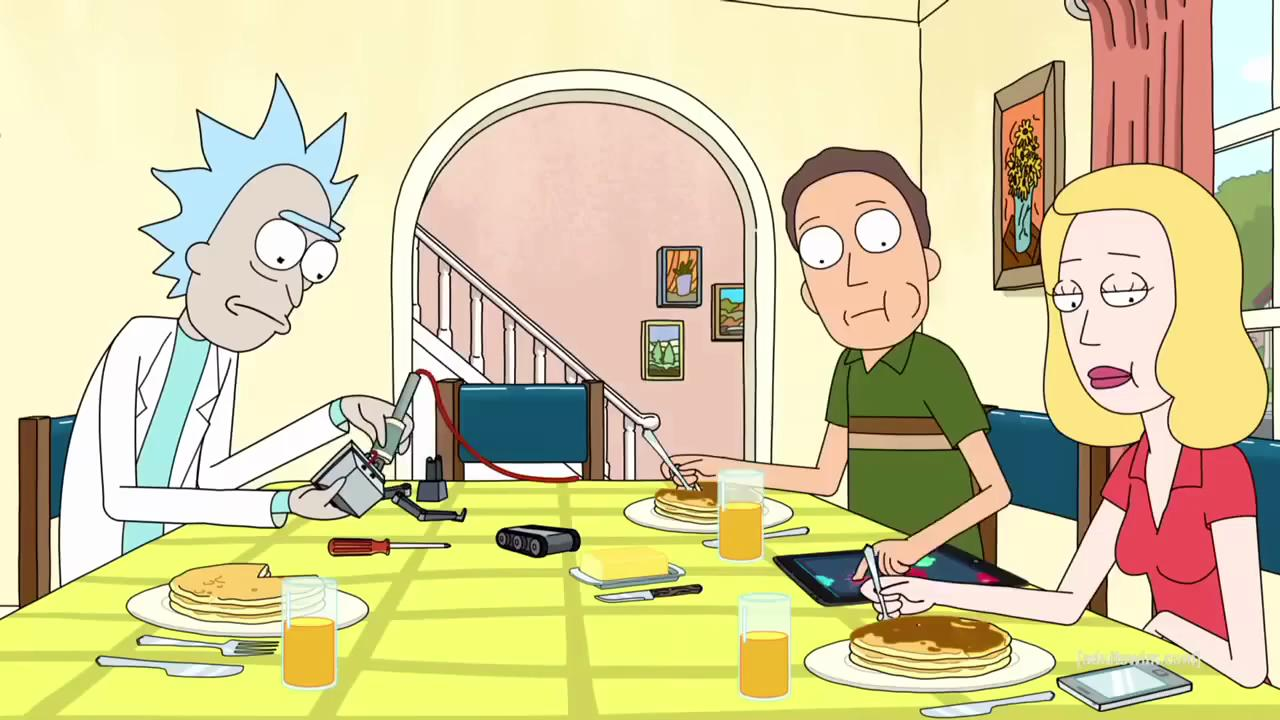

In [5]:
video_table.show()

Do you recognise this Rick & Morty episode? 

### Step 1: Extracting the audio from the video

Added 1 column value with 0 errors.


video,audio
,

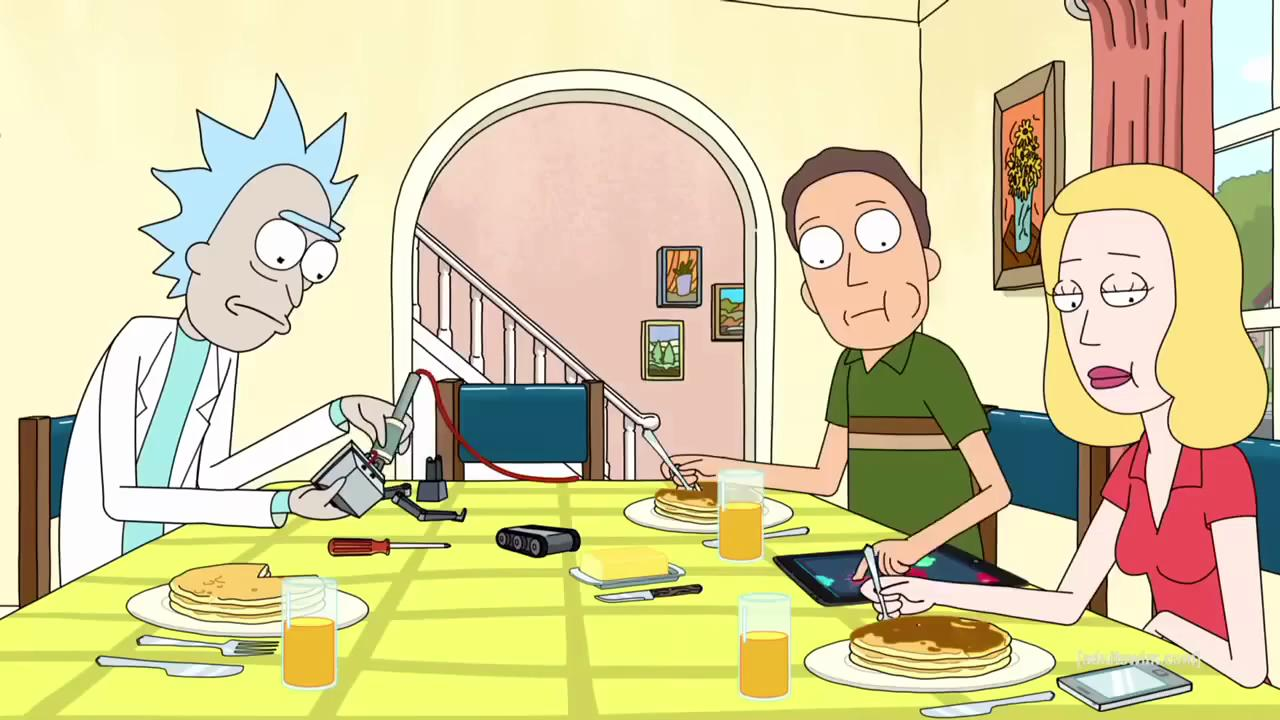

In [6]:
from pixeltable.functions.video import extract_audio

video_table.add_computed_column(
    audio=extract_audio(video_table.video, format='mp3'),
    if_exists="ignore"
)
video_table.show()


As you can see in the table above, we have two columns now. One column contains the video, and the other column contains the audio. Now, we need to split the audio into chunks.

### Step 2: Splitting the audio

In [7]:
from pixeltable.iterators.audio import AudioSplitter

audio_view = pxt.create_view(
    "test.audio_chunks",
    video_table,
    iterator = AudioSplitter.create(
        audio=video_table.audio,
        chunk_duration_sec=5.0,
        overlap_sec=1.0,
        min_chunk_duration_sec=5.0
    ),
    if_exists="ignore"
)

Inserting rows into `audio_chunks`: 14 rows [00:00, 471.10 rows/s]
Created view `audio_chunks` with 14 rows, 0 exceptions.


pos,start_time_sec,end_time_sec,audio_chunk,video,audio
0,0.023,5.016,,,
1,4.032,9.,,,

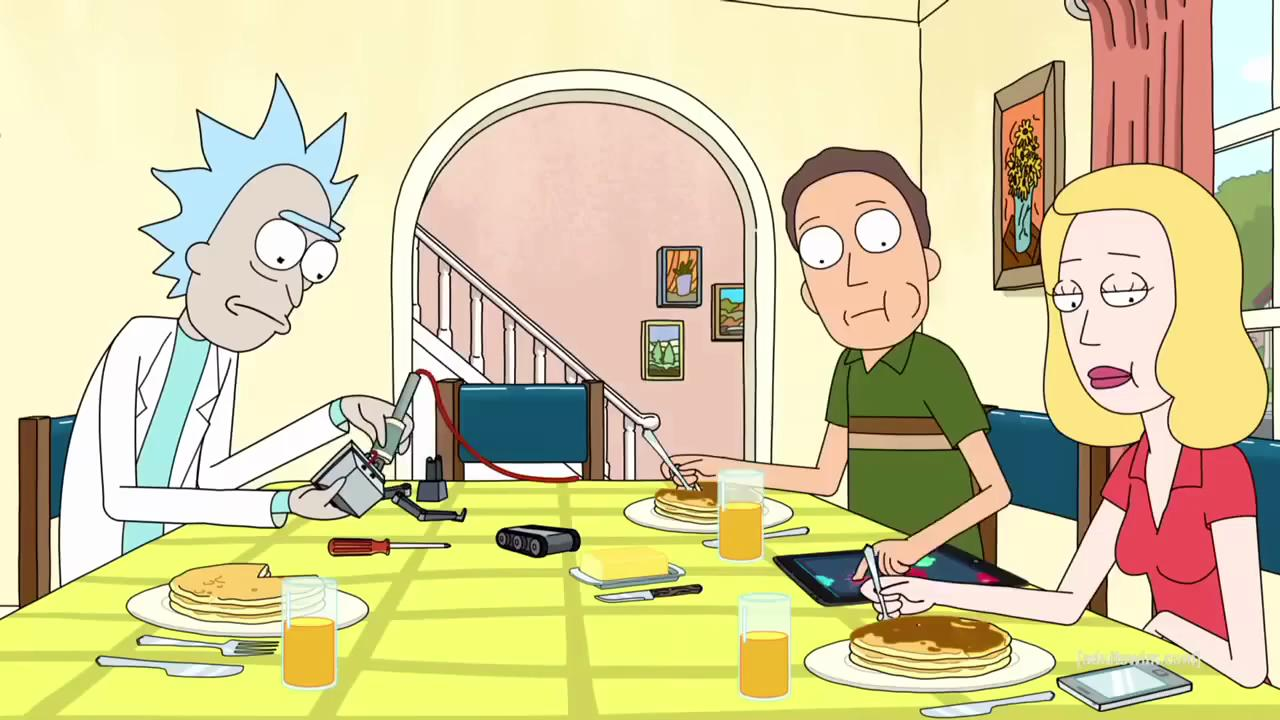
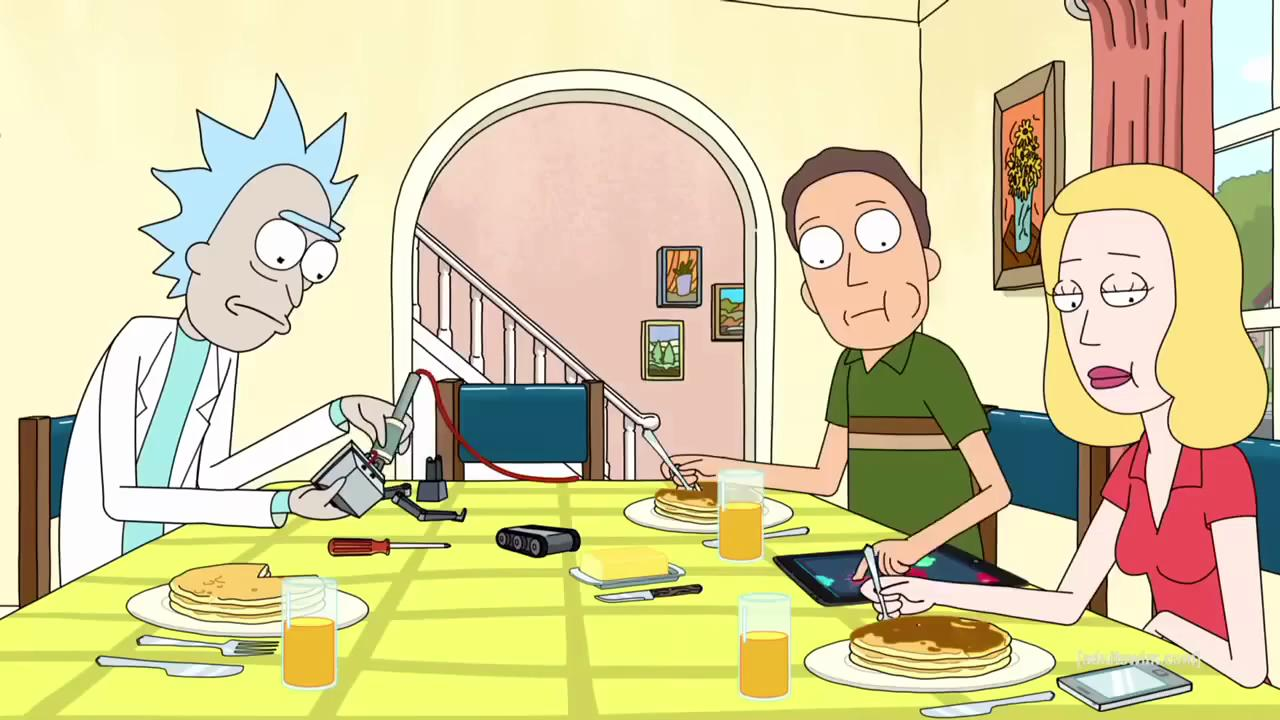

In [8]:
audio_view.show(2)

Notice that, apart from the `audio_chunk` column, we also have two additional columns, giving information about the start and end time in seconds.

### Step 3: Transcription with Whisper

In [9]:
from pixeltable.functions import whisper

audio_view.add_computed_column(
    transcription=whisper.transcribe(
        audio=audio_view.audio_chunk, model="base.en"
    ),
)

/Users/moteroperdido/Desktop/projects/the_neural_maze/projects/multimodal-agents-course/mcp-server/.venv/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/moteroperdido/Desktop/projects/the_neural_maze/projects/multimodal-agents-course/mcp-server/.venv/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/moteroperdido/Desktop/projects/the_neural_maze/projects/multimodal-agents-course/mcp-server/.venv/lib/python3.12/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/Users/moteroperdido/Desktop/projects/the_neural_maze/projects/multimodal-agents-course/mcp-server/.venv/lib/python3.12/site-pa

Added 14 column values with 0 errors.


UpdateStatus(num_rows=14, num_computed_values=14, num_excs=0, updated_cols=[], cols_with_excs=[])

pos,start_time_sec,end_time_sec,audio_chunk,transcription,video,audio
0,0.023,5.016,,"{""text"": "" Hey Rick, I have to make a project for the science fair this week."", ""language"": ""en"", ""segments"": [{""id"": 0, ""end"": 5., ""seek"": 0, ""text"": "" Hey Rick, I have to make a project for the science fair this week."", ""start"": 0., ""tokens"": [50363, 14690, 8759, 11, 314, 423, ..., 3783, 3148, 428, 1285, 13, 50613], ""avg_logprob"": -0.319, ""temperature"": 0., ""no_speech_prob"": 0.177, ""compression_ratio"": 0.957}]}",,

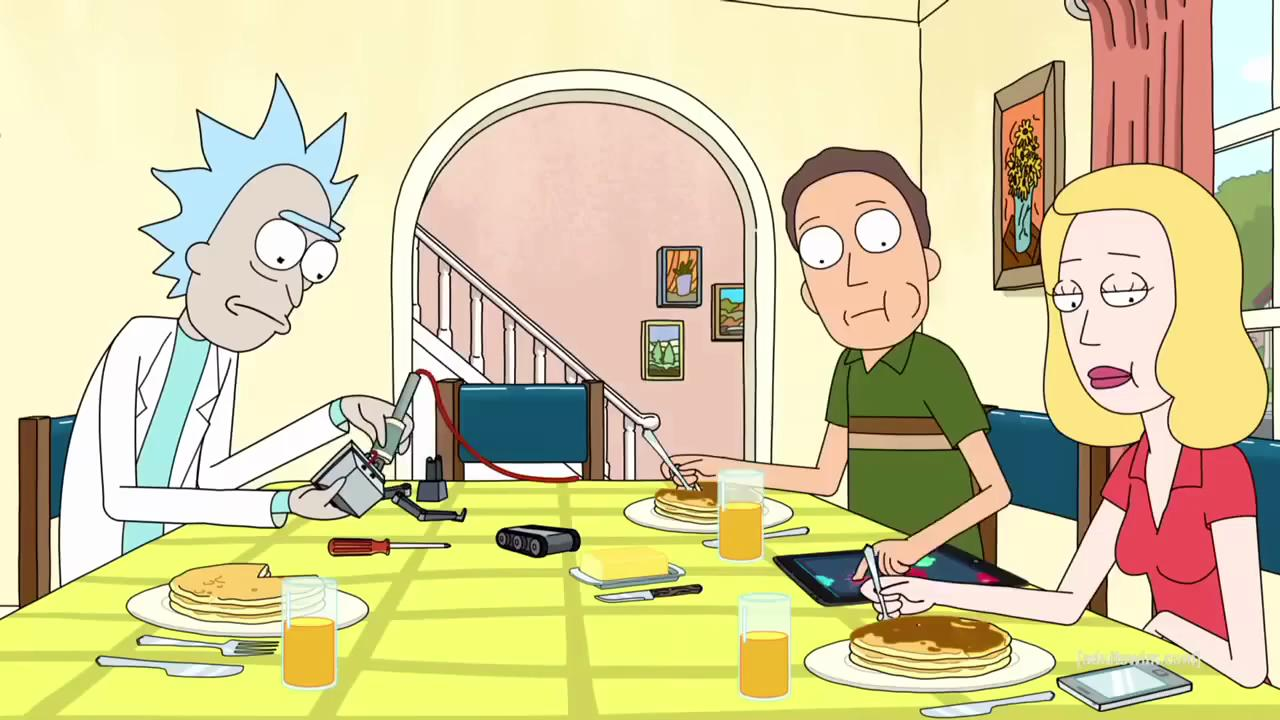

In [10]:
audio_view.order_by(audio_view.pos).show(1)

A new column has appeared, containing the transcription about the corresponding audio chunk! If you look at the content, you'll notice it has a lot of metadata information. We just need the `text` attribute. 

### Step 4: Extracting the text from the transcription

In [11]:
from mcp_server.video_ingestion.functions import extract_text_from_chunk


audio_view.add_computed_column(
    chunk_text=extract_text_from_chunk(audio_view.transcription),
    if_exists="ignore",
)

Added 14 column values with 0 errors.


UpdateStatus(num_rows=14, num_computed_values=14, num_excs=0, updated_cols=[], cols_with_excs=[])

pos,start_time_sec,end_time_sec,audio_chunk,transcription,chunk_text,video,audio
0,0.023,5.016,,"{""text"": "" Hey Rick, I have to make a project for the science fair this week."", ""language"": ""en"", ""segments"": [{""id"": 0, ""end"": 5., ""seek"": 0, ""text"": "" Hey Rick, I have to make a project for the science fair this week."", ""start"": 0., ""tokens"": [50363, 14690, 8759, 11, 314, 423, ..., 3783, 3148, 428, 1285, 13, 50613], ""avg_logprob"": -0.319, ""temperature"": 0., ""no_speech_prob"": 0.177, ""compression_ratio"": 0.957}]}","Hey Rick, I have to make a project for the science fair this week.",,

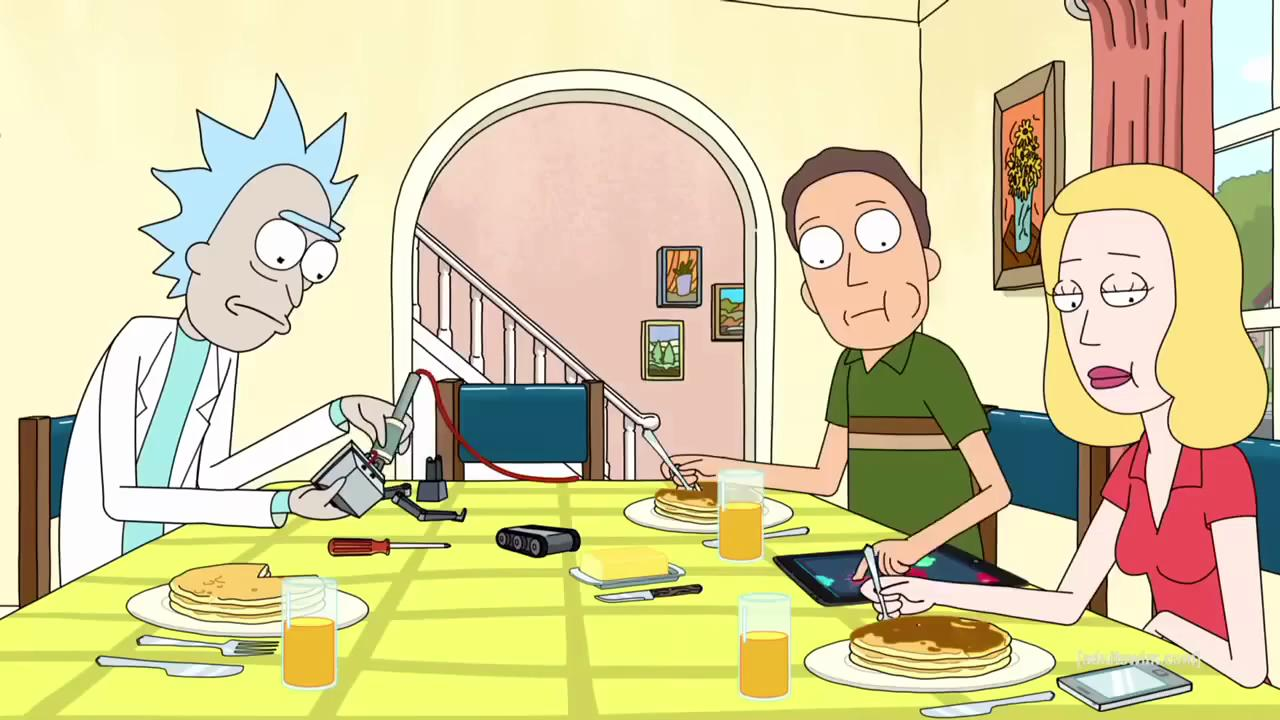

In [12]:
audio_view.order_by(audio_view.pos).show(1)

If you look at the `chunk_text` column, you'll see the text transcription (just the string).

### Step 5: Creating an embedding index for audio transcriptions

In [13]:
from pixeltable.functions.huggingface import sentence_transformer


audio_view.add_embedding_index(
    column=audio_view.chunk_text,
    string_embed=sentence_transformer.using(model_id="intfloat/e5-large-v2"),
    if_exists="ignore",
    idx_name="chunks_index",
)

You can check how this embedding index works by passing some query. The code below will take care of check the most similar audio_chunk to the user query.

In [14]:
audio_sims = audio_view.chunk_text.similarity("Pass the butter")

In [15]:
results = audio_view.select(
    audio_view.pos,
    audio_view.start_time_sec,
    audio_view.end_time_sec,
    similarity=audio_sims,
).order_by(audio_sims, asc=False)

In [16]:
top_k_entry = results.limit(1).collect()[0]

In [17]:
top_k_entry

{'pos': 8,
 'start_time_sec': 32.04,
 'end_time_sec': 37.0081,
 'similarity': 0.8820397924161096}

We can check the clip by using the `extract_video_clip` helper function.

In [32]:
from mcp_server.video_ingestion.tools import extract_video_clip

video_clip = extract_video_clip(
    video_path=video_path, 
    start_time=top_k_entry["start_time_sec"], 
    end_time=top_k_entry["end_time_sec"],
    output_path="./data/pass_the_butter_clip_sim_audio.mp4",
)

MoviePy - Building video ./data/pass_the_butter_clip_sim_audio.mp4.
MoviePy - Writing audio in pass_the_butter_clip_sim_audioTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video ./data/pass_the_butter_clip_sim_audio.mp4



MoviePy - Done !
MoviePy - video ready ./data/pass_the_butter_clip_sim_audio.mp4


In [34]:
from IPython.display import Video

Video(video_clip.filename)

### Step 6: Splitting the video in frames

In [28]:
from pixeltable.iterators.video import FrameIterator

frames_view = pxt.create_view(
    "test.frames_view",
    video_table,
    iterator=FrameIterator.create(
        video=video_table.video, fps=0.5
    ),
    if_exists="ignore",
)

Inserting rows into `frames_view`: 31 rows [00:00, 9328.70 rows/s]
Created view `frames_view` with 31 rows, 0 exceptions.


pos,frame_idx,pos_msec,pos_frame,frame,video,audio
0,0,0.,0,,,
1,1,2002.,60,,,
2,2,4004.,120,,,

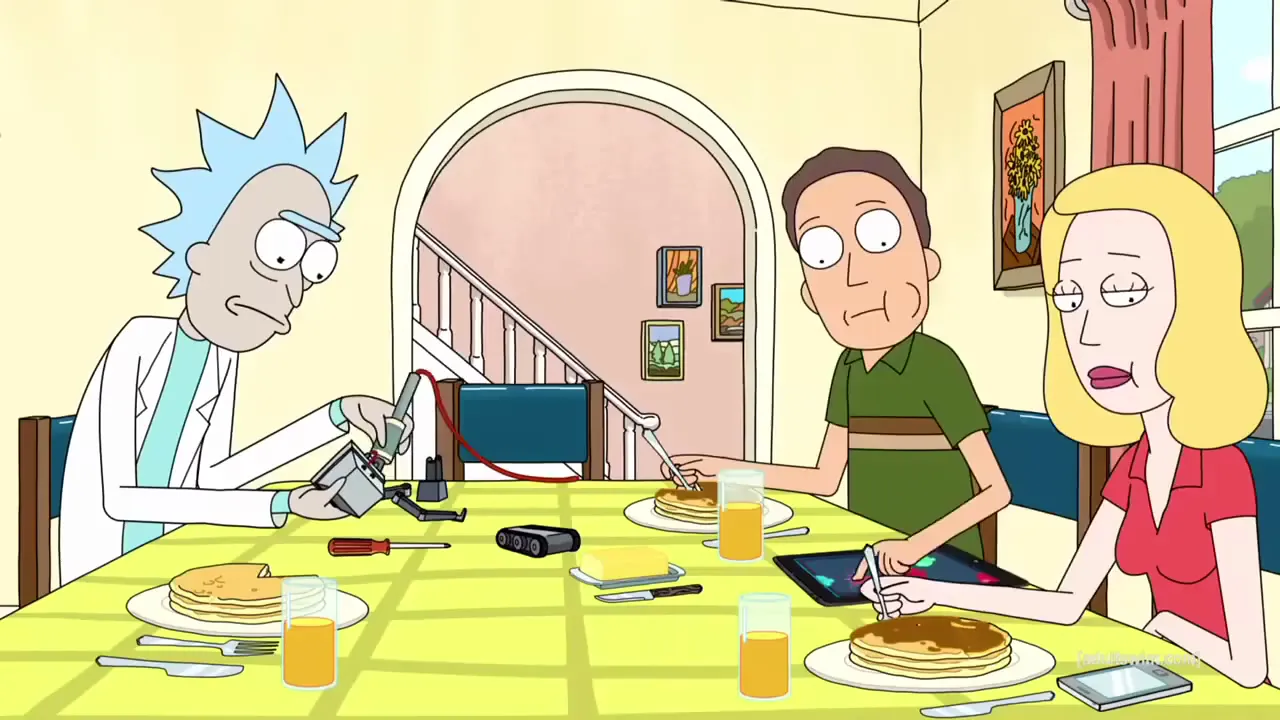
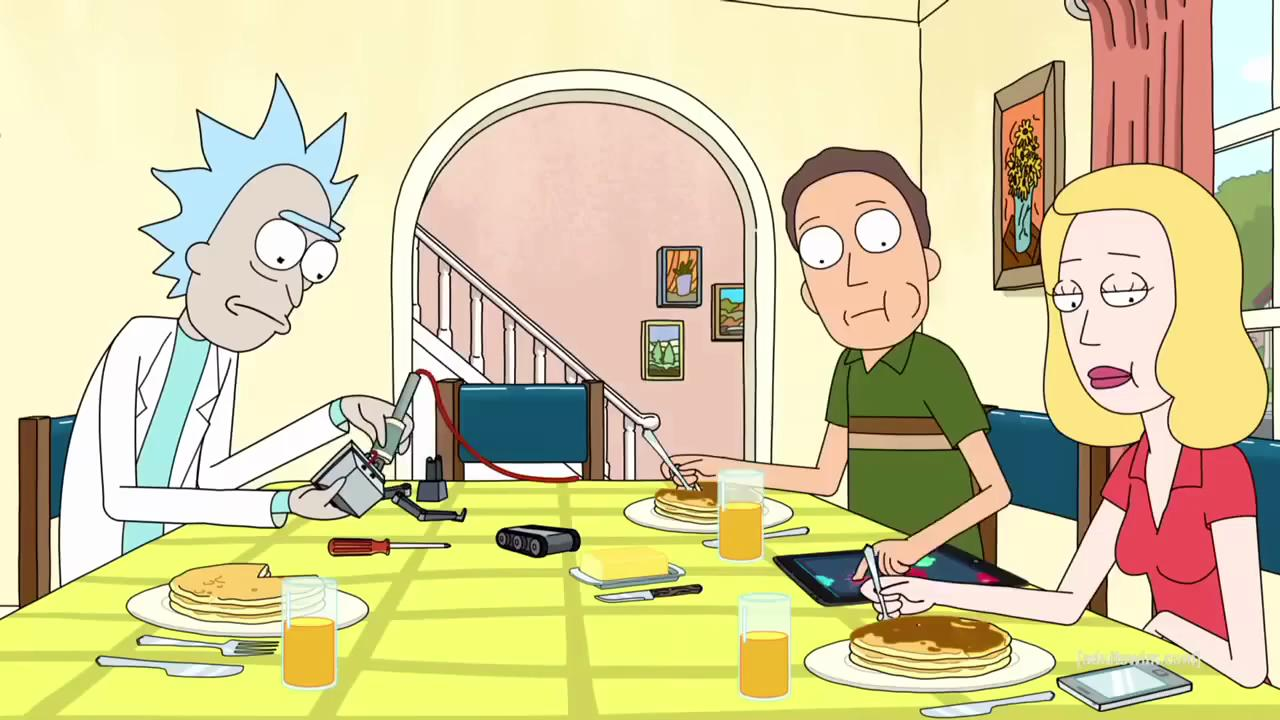
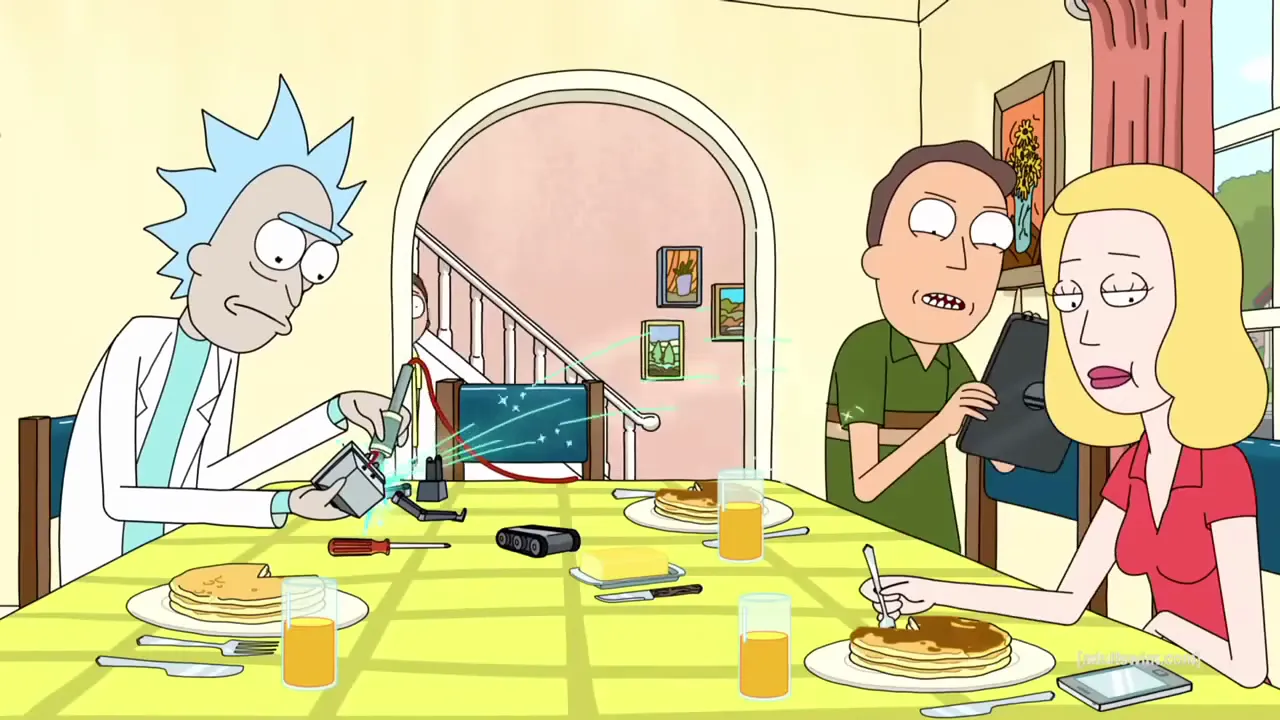
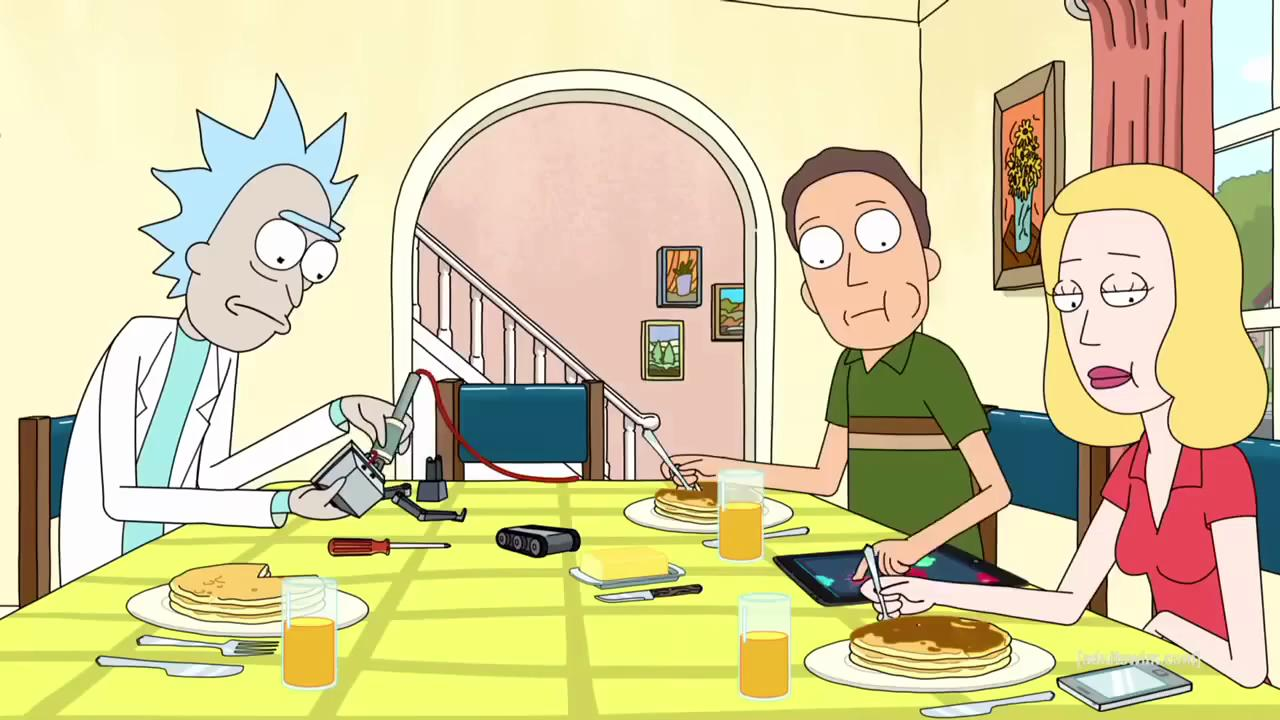
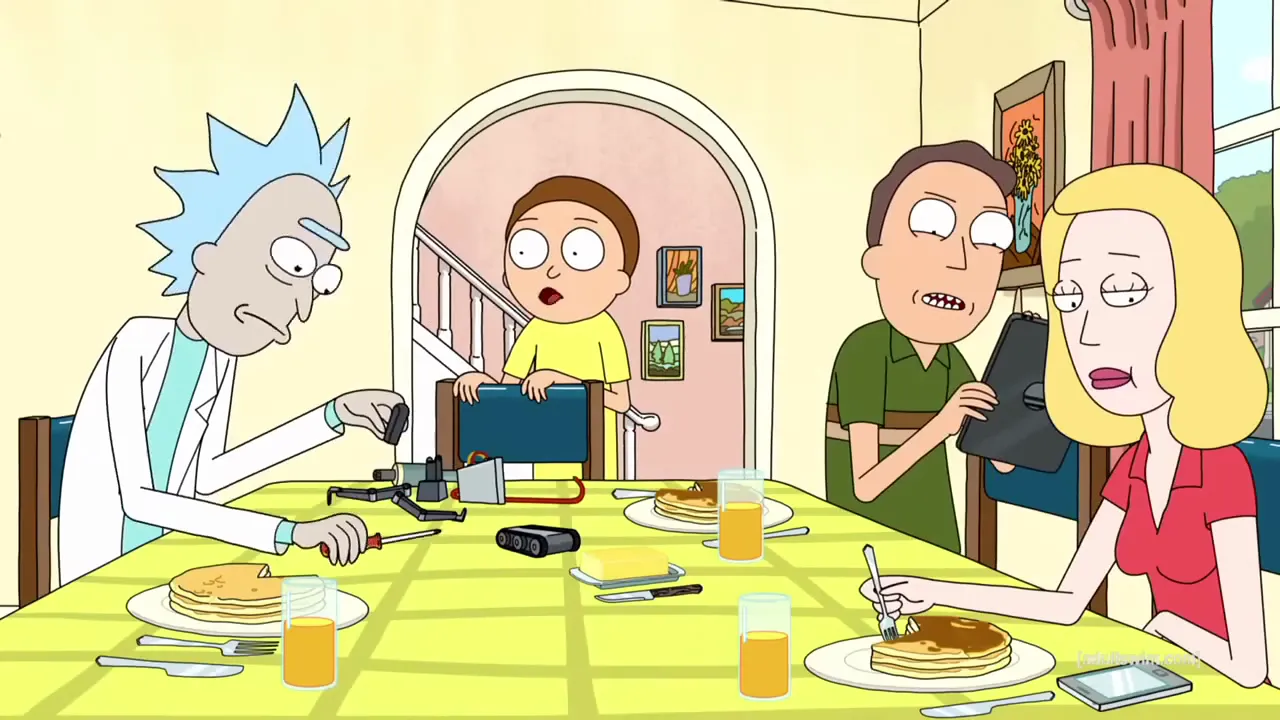
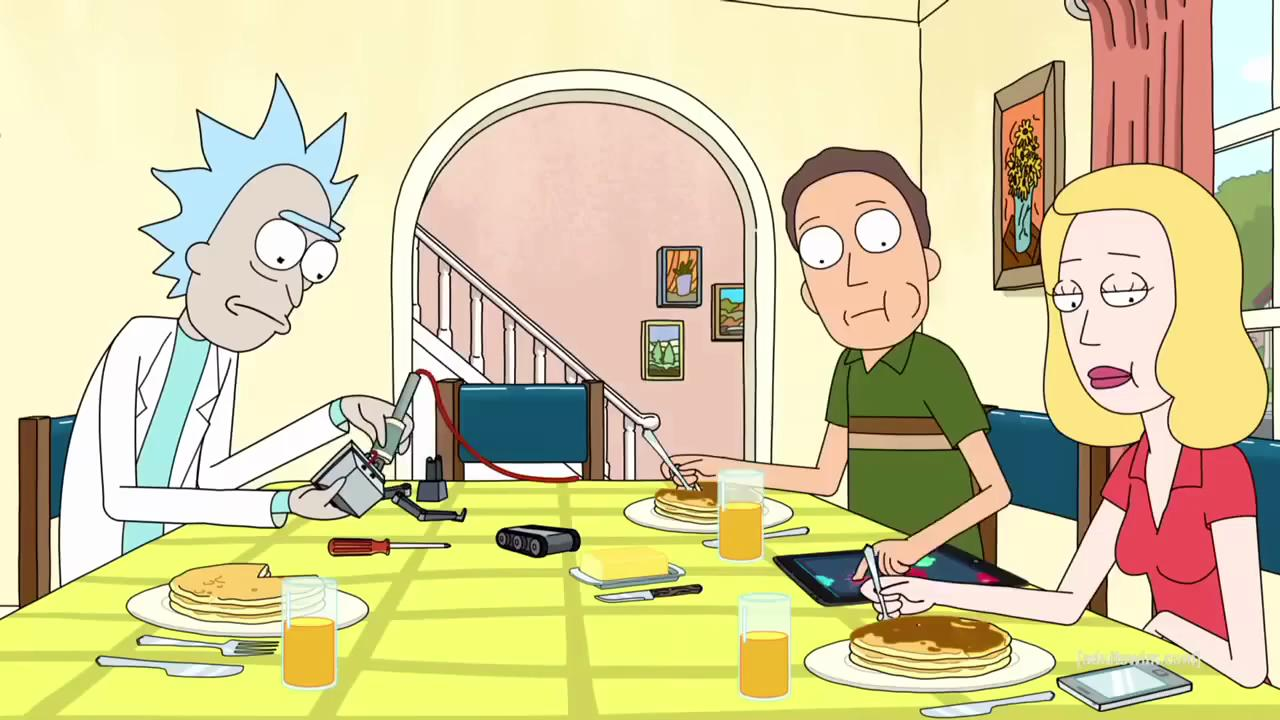

In [30]:
frames_view.show(3)

To access visual content, we need to sample the video, placing each frame in a row. After that, we just need to create an embedding index for the frames. We'll use CLIP embeddings for this one.

### Step 7: Creating frame embedding index

In [35]:
from pixeltable.functions.huggingface import clip

frames_view.add_embedding_index(
    column=frames_view.frame,
    image_embed=clip.using(model_id="openai/clip-vit-base-patch32"),
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


As we did with the audio embedding index, we can also provide an image and check the clip more similar to it. For example, let's use the following picture.

In [55]:
from PIL import Image

img = Image.open("./data/sad_robot.png")

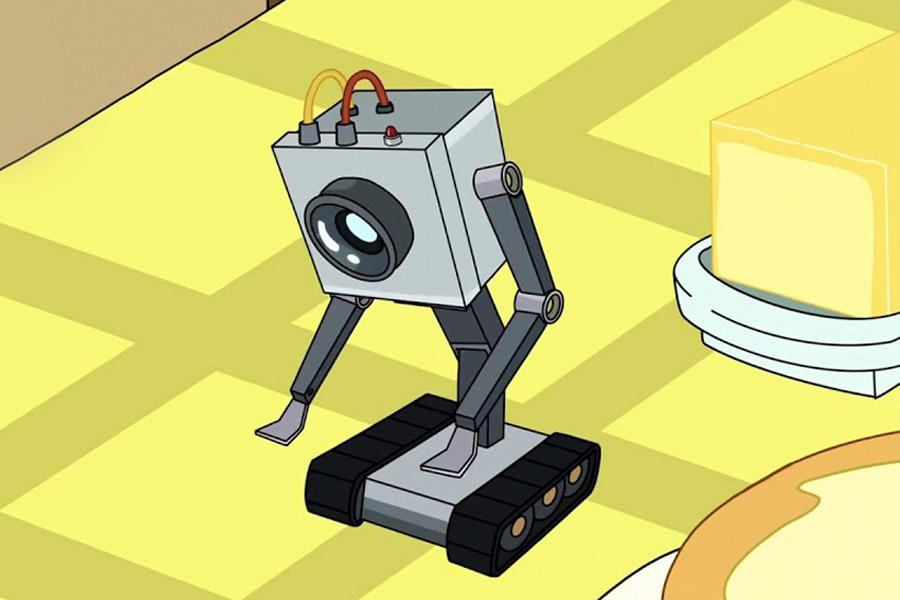

In [56]:
img

In [57]:
image_sims = frames_view.frame.similarity(img)

In [58]:
results = frames_view.select(
    frames_view.pos_msec,
    frames_view.frame,
    similarity=image_sims,
).order_by(image_sims, asc=False)

In [59]:
top_k_entry = results.limit(1).collect()[0]

In [60]:
top_k_entry

{'pos_msec': 55989.26666666667,
 'frame': <PIL.Image.Image image mode=RGB size=1280x720>,
 'similarity': 0.9272637085594415}

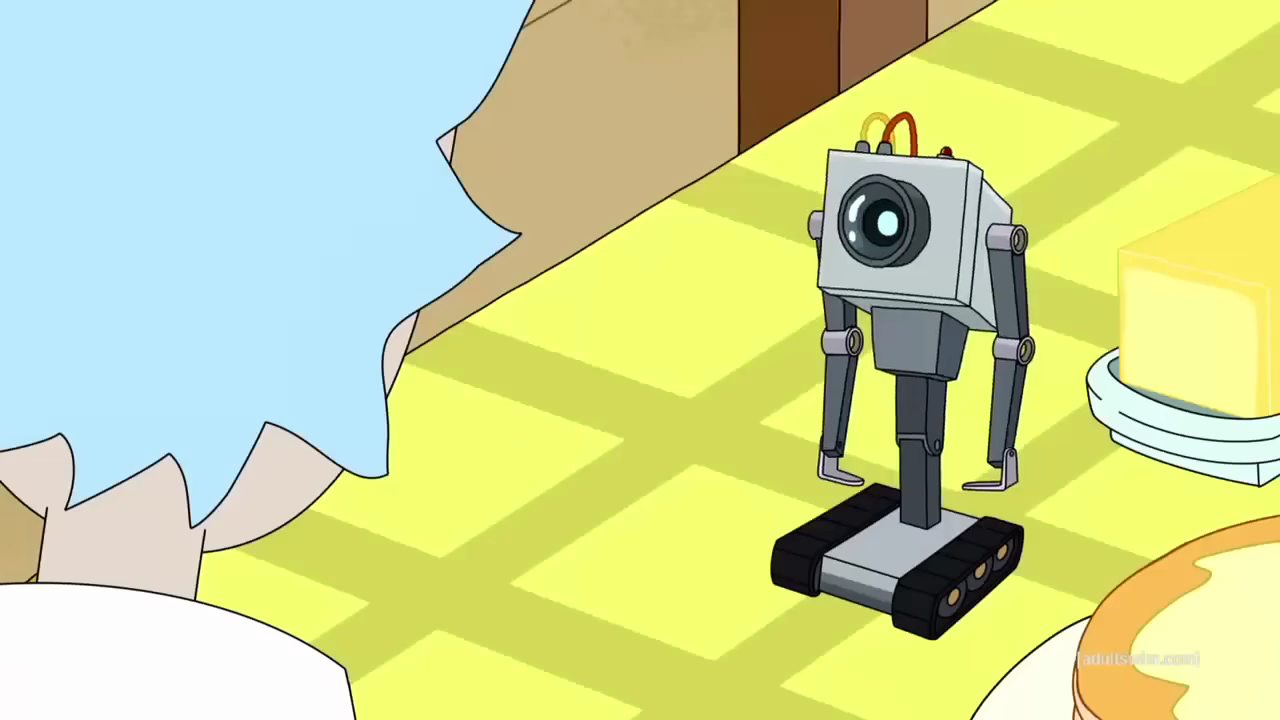

In [64]:
top_k_entry["frame"]

In [62]:
from mcp_server.video_ingestion.tools import extract_video_clip

video_clip = extract_video_clip(
    video_path=video_path, 
    start_time=top_k_entry["pos_msec"] / 1000. - 3, 
    end_time=top_k_entry["pos_msec"] / 1000. + 3,
    output_path="./data/pass_the_butter_clip_sim_image.mp4",
)

MoviePy - Building video ./data/pass_the_butter_clip_sim_image.mp4.
MoviePy - Writing audio in pass_the_butter_clip_sim_imageTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video ./data/pass_the_butter_clip_sim_image.mp4



MoviePy - Done !
MoviePy - video ready ./data/pass_the_butter_clip_sim_image.mp4


In [63]:
from IPython.display import Video

Video(video_clip.filename)

### Step 8: Add captions for each frame

In [87]:
from mcp_server.video_ingestion.functions import caption_image


frames_view.add_computed_column(
    im_caption=caption_image(
        image=frames_view.frame,
        prompt="Describe what you see in the image in just a sentence."
    ),
    if_exists="replace"
)

2025-06-02 18:23:24.000 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:24.770 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:25.451 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:26.111 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:26.670 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:29.386 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:33.788 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:37.792 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Image successfully captioned
2025-06-02 18:23:41.565 | INFO     | mcp_server.video_ingestion.caption:caption:95 - Ima

Added 31 column values with 0 errors.


UpdateStatus(num_rows=31, num_computed_values=31, num_excs=0, updated_cols=[], cols_with_excs=[])

pos,frame_idx,pos_msec,pos_frame,frame,im_caption,video,audio
0,0,0.,0,,"The image shows a still from the animated television show Rick and Morty. Three characters are sitting around a table. Rick is on the left with spiky blue hair and white lab coat. A man and a woman are on the right. They are eating pancakes and appear to be on their phones. The table is yellow with plates of pancakes, glasses of orange juice and various phones and tools. In the background is a pink wall with pieces of art hanging on it. A stairway leads away from the scene.",,

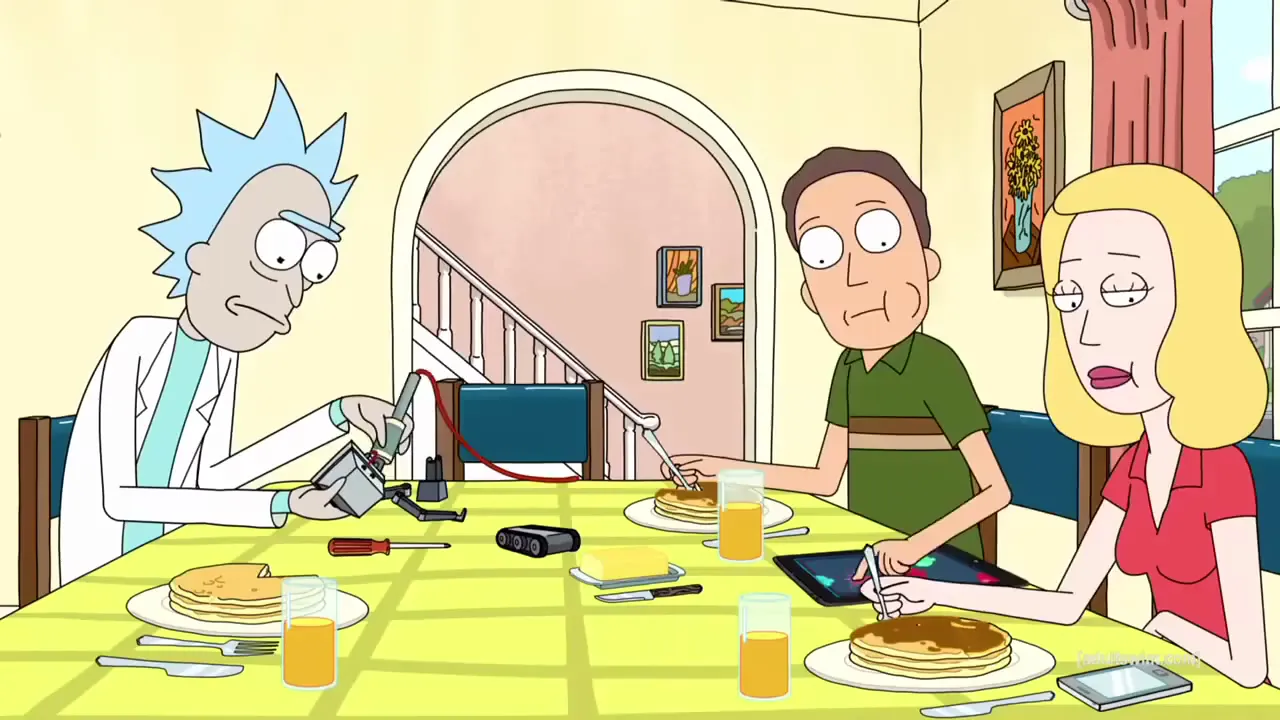
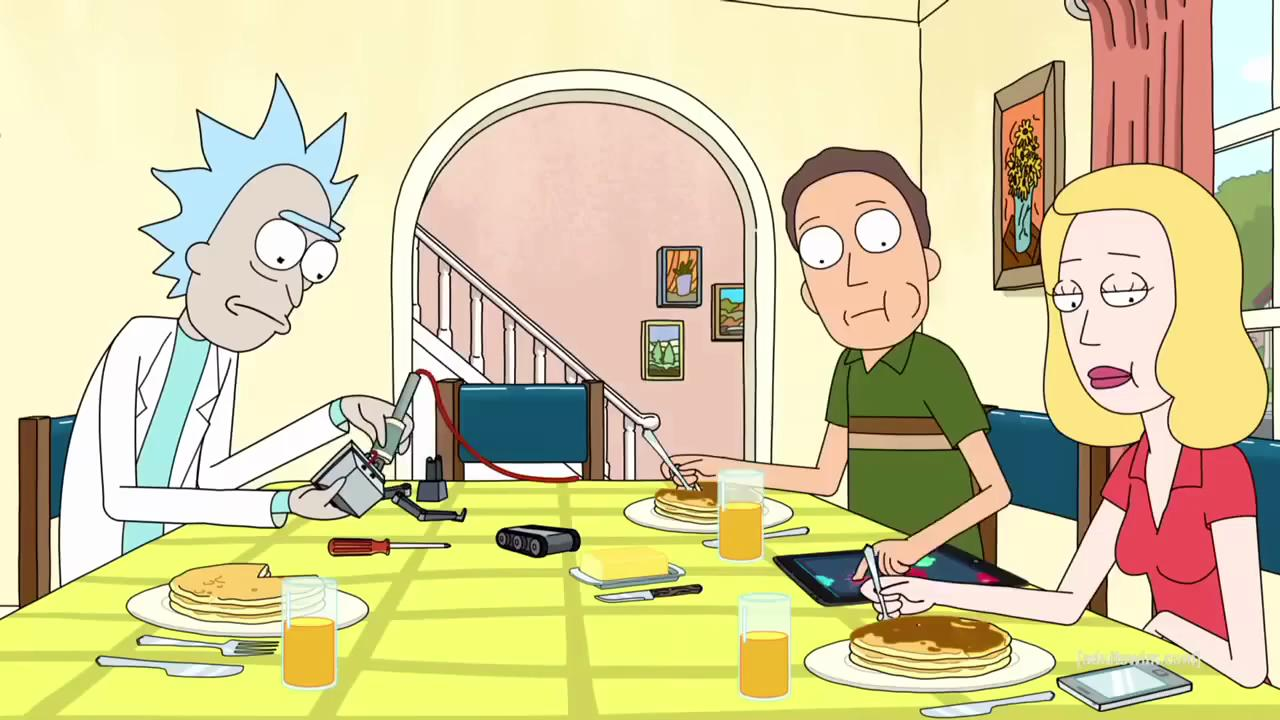

In [88]:
frames_view.show(1)

### Step 9: Creating caption embedding index

In [89]:
frames_view.add_embedding_index(
    column=frames_view.im_caption,
    string_embed=clip.using(model_id="openai/clip-vit-base-patch32"),
)

In [96]:
caption_sims = frames_view.im_caption.similarity("Your father is insecure about his intelligence")

In [97]:
caption_sims

im_caption.similarity('Your father is insecure about his intelligence')

In [102]:
results = frames_view.select(
    frames_view.pos_msec,
    frames_view.im_caption,
    similarity=caption_sims,
).order_by(caption_sims, asc=False)

In [106]:
top_k_entry = results.limit(1).collect()[0]

In [107]:
top_k_entry

{'pos_msec': 19986.633333333335,
 'im_caption': 'The image depicts a cartoon-style illustration of a person holding a cell phone with a text message from "Mom" that reads, "Your father is insecure about his intelligence."',
 'similarity': 0.7189651367261967}

In [108]:
from mcp_server.video_ingestion.tools import extract_video_clip

video_clip = extract_video_clip(
    video_path=video_path, 
    start_time=top_k_entry["pos_msec"] / 1000. - 3, 
    end_time=top_k_entry["pos_msec"] / 1000. + 3,
    output_path="./data/pass_the_butter_clip_sim_caption.mp4",
)

MoviePy - Building video ./data/pass_the_butter_clip_sim_caption.mp4.
MoviePy - Writing audio in pass_the_butter_clip_sim_captionTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video ./data/pass_the_butter_clip_sim_caption.mp4



MoviePy - Done !
MoviePy - video ready ./data/pass_the_butter_clip_sim_caption.mp4


In [109]:
from IPython.display import Video

Video(video_clip.filename)

### Conclusion

These three embedding indexes will be used used by our MCP Server to fetch the most relevant content from the videos. But of course, the Agent won't be aware of the inner workings, since that's exactly the goal of the MCP Server!